In [1]:
import numpy as np 
import pandas as pd

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
import os
import cv2

In [3]:
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
import tensorflow as tf
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam,SGD
from keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.backend import clear_session

In [4]:
train_path = r"C:\Users\khima\Downloads\braintumour\Training"
test_path = r"C:\Users\khima\Downloads\braintumour\Testing"

In [5]:
folds=os.listdir(train_path)
file=[]
label=[]
for fold in folds:
    file_path=os.path.join(train_path,fold)
    images=os.listdir(file_path)
    
    for image in images:
        file.append(os.path.join(file_path,image))
        label.append(fold)
        

files=pd.Series(file)
labels=pd.Series(label)

train_data=pd.concat([files,labels],axis=1)
train_df=pd.DataFrame(train_data)
train_df.columns=['file','label']

In [6]:
file=[]
label=[]
folds=os.listdir(test_path)
for fold in folds:
    file_path=os.path.join(test_path,fold)
    images=os.listdir(file_path)
    
    for image in images:
        file.append(os.path.join(file_path,image))
        label.append(fold)
        

files=pd.Series(file)
labels=pd.Series(label)

test_data=pd.concat([files,labels],axis=1)
test_df=pd.DataFrame(test_data)
test_df.columns=['file','label']

In [7]:
train_df,validation_df = train_test_split(train_df,test_size=0.2,random_state=42,shuffle=True)

In [8]:
generator=ImageDataGenerator()

def create_dataset(df, shuffle = False):
    return generator.flow_from_dataframe(df, class_mode="categorical",x_col='file',y_col='label',shuffle=shuffle)

train_dataset = create_dataset(train_df,shuffle=True) 
valid_dataset = create_dataset(validation_df)
test_dataset = create_dataset(test_df)

Found 2296 validated image filenames belonging to 4 classes.
Found 574 validated image filenames belonging to 4 classes.
Found 308 validated image filenames belonging to 4 classes.


In [9]:
label_dict = train_dataset.class_indices
tumor_type = list(label_dict.keys())
images,labels=next(train_dataset)

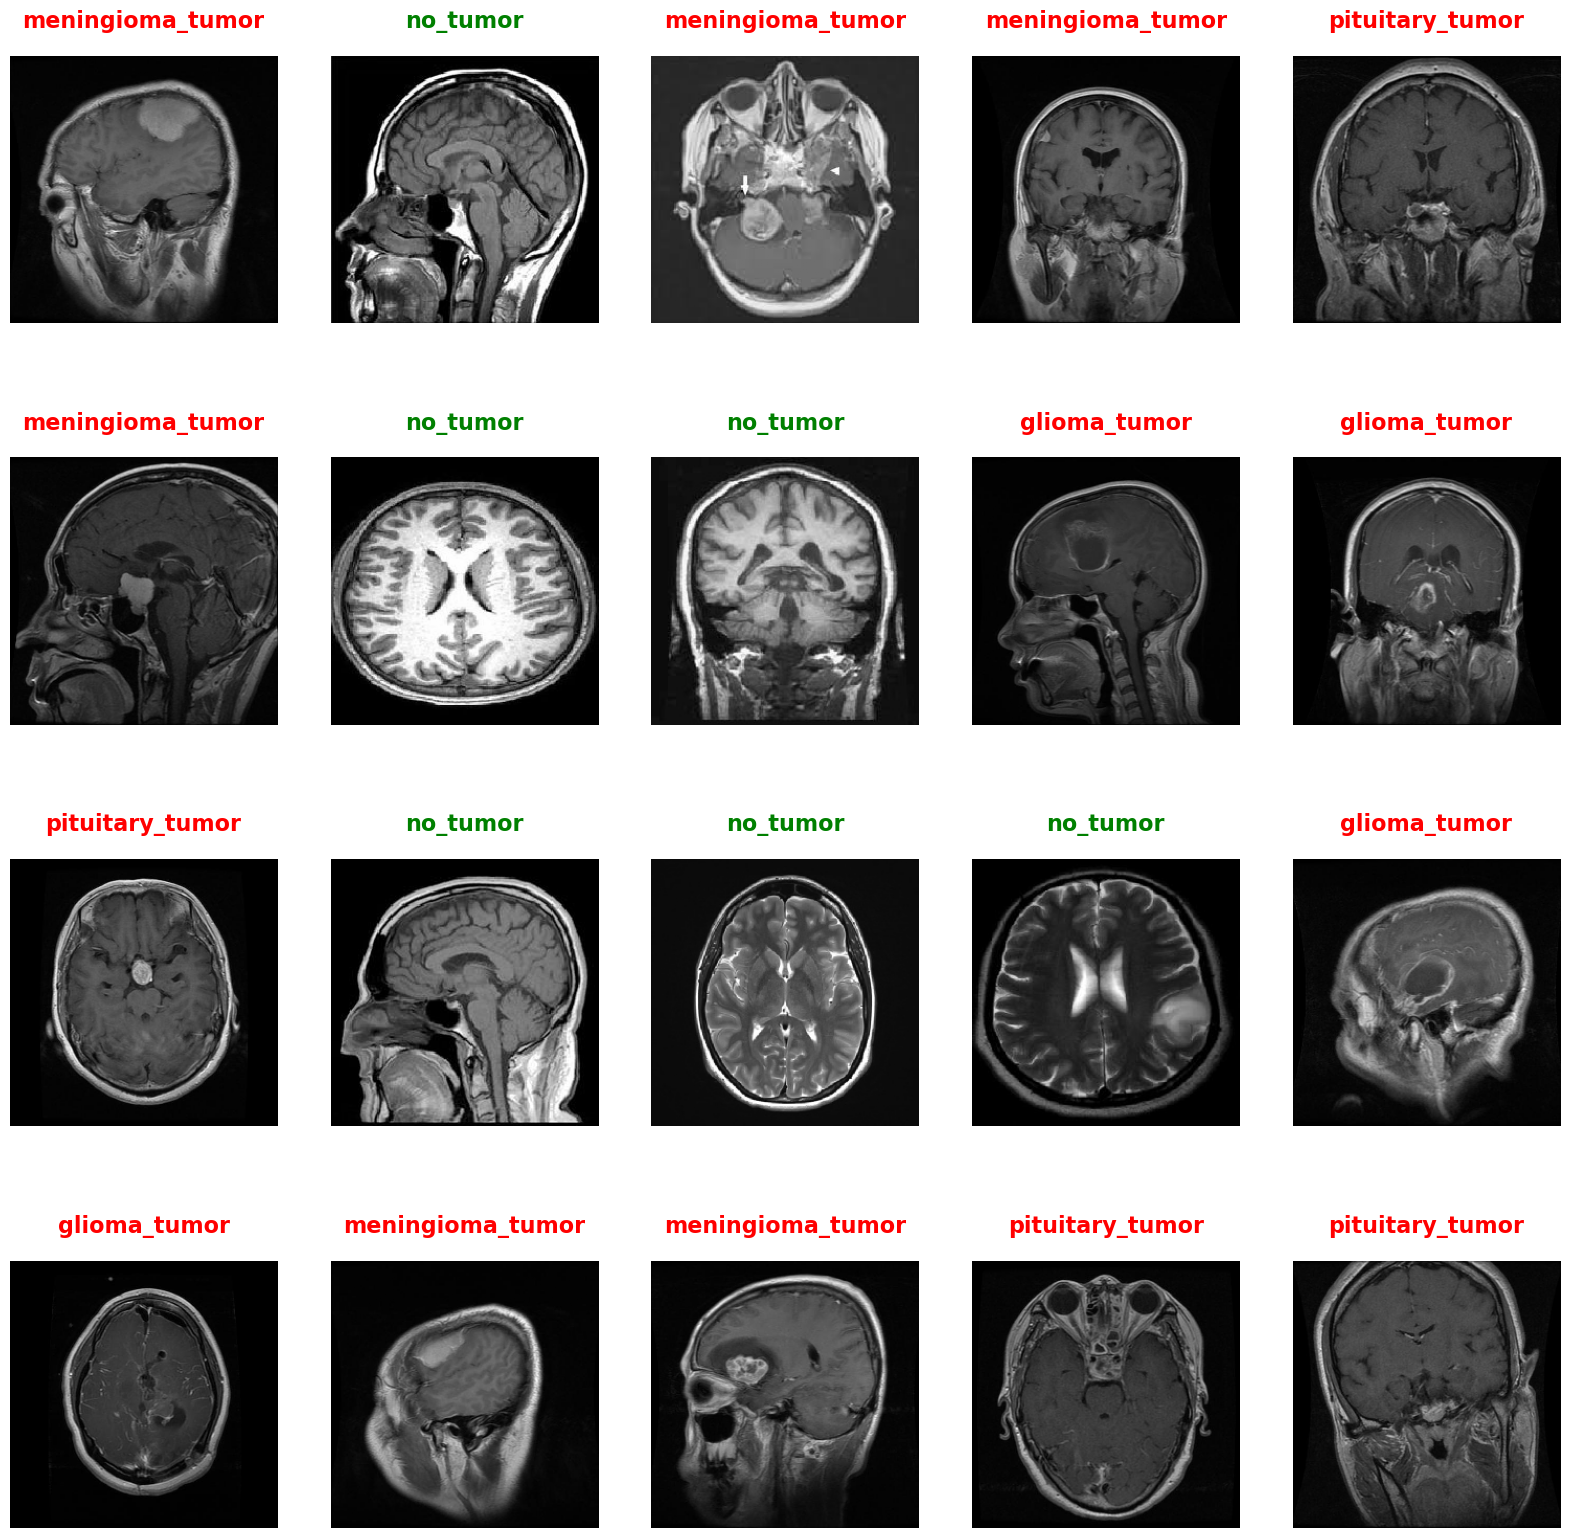

In [12]:
from matplotlib import rcParams

plt.figure(figsize= (20,20))
rcParams['axes.titlepad'] = 20

for i in range(20):
    plt.subplot(4,5,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    tumor_type_name = tumor_type[index]
    color = 'green' if tumor_type_name == 'no_tumor' else 'red'
    plt.title(tumor_type_name, fontsize=16, fontweight='bold', color=color)
    plt.axis('off')

plt.show()


In [13]:
# Fixing the seed for random number generators
import random
clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [14]:
effnetb3_model=EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling='max',
    classifier_activation="softmax",
)

for layer in effnetb3_model.layers:
    layer.trainable = False
    
model = Sequential()

model.add(effnetb3_model)
model.add(BatchNormalization(axis=-1, momentum=0.016))
model.add(Dense(432, kernel_regularizer=regularizers.l1(0.00016219569284178702), activation='relu'))
model.add(Dropout(0.24377169383011632))
model.add(Dense(4, activation='softmax'))


In [15]:
opt = SGD(learning_rate=0.008853510984551376, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 432)               663984    
                                                                 
 dropout (Dropout)           (None, 432)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1732      
                                                                 
Total params: 11455395 (43.70 MB)
Trainable params: 6687

In [16]:
model_checkpoint_filpath5 = "model_checkpoint.h5"
callbacks_checkpoints5 = ModelCheckpoint(

    filepath = model_checkpoint_filpath5,
    save_weights_only = True,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True
)

In [17]:
history = model.fit(train_dataset,
                    epochs = 20,
                    validation_data = valid_dataset,
                    callbacks = [callbacks_checkpoints5]
                    )

Epoch 1/20


72/72 [==============================] - 122s 2s/step - loss: 3.6835 - accuracy: 0.7252 - val_loss: 3.3014 - val_accuracy: 0.8449
Epoch 2/20
72/72 [==============================] - 115s 2s/step - loss: 3.1956 - accuracy: 0.8624 - val_loss: 3.1305 - val_accuracy: 0.8606
Epoch 3/20
72/72 [==============================] - 103s 1s/step - loss: 2.9810 - accuracy: 0.9064 - val_loss: 2.9967 - val_accuracy: 0.8815
Epoch 4/20
72/72 [==============================] - 105s 1s/step - loss: 2.9037 - accuracy: 0.9055 - val_loss: 2.9645 - val_accuracy: 0.8798
Epoch 5/20
72/72 [==============================] - 104s 1s/step - loss: 2.7443 - accuracy: 0.9238 - val_loss: 2.8590 - val_accuracy: 0.8850
Epoch 6/20
72/72 [==============================] - 104s 1s/step - loss: 2.6186 - accuracy: 0.9421 - val_loss: 2.7337 - val_accuracy: 0.8955
Epoch 7/20
72/72 [==============================] - 104s 1s/step - loss: 2.4936 - accuracy: 0.9556 - val_loss: 2.5784 - val_accuracy: 0.9181
Epoch 8/20


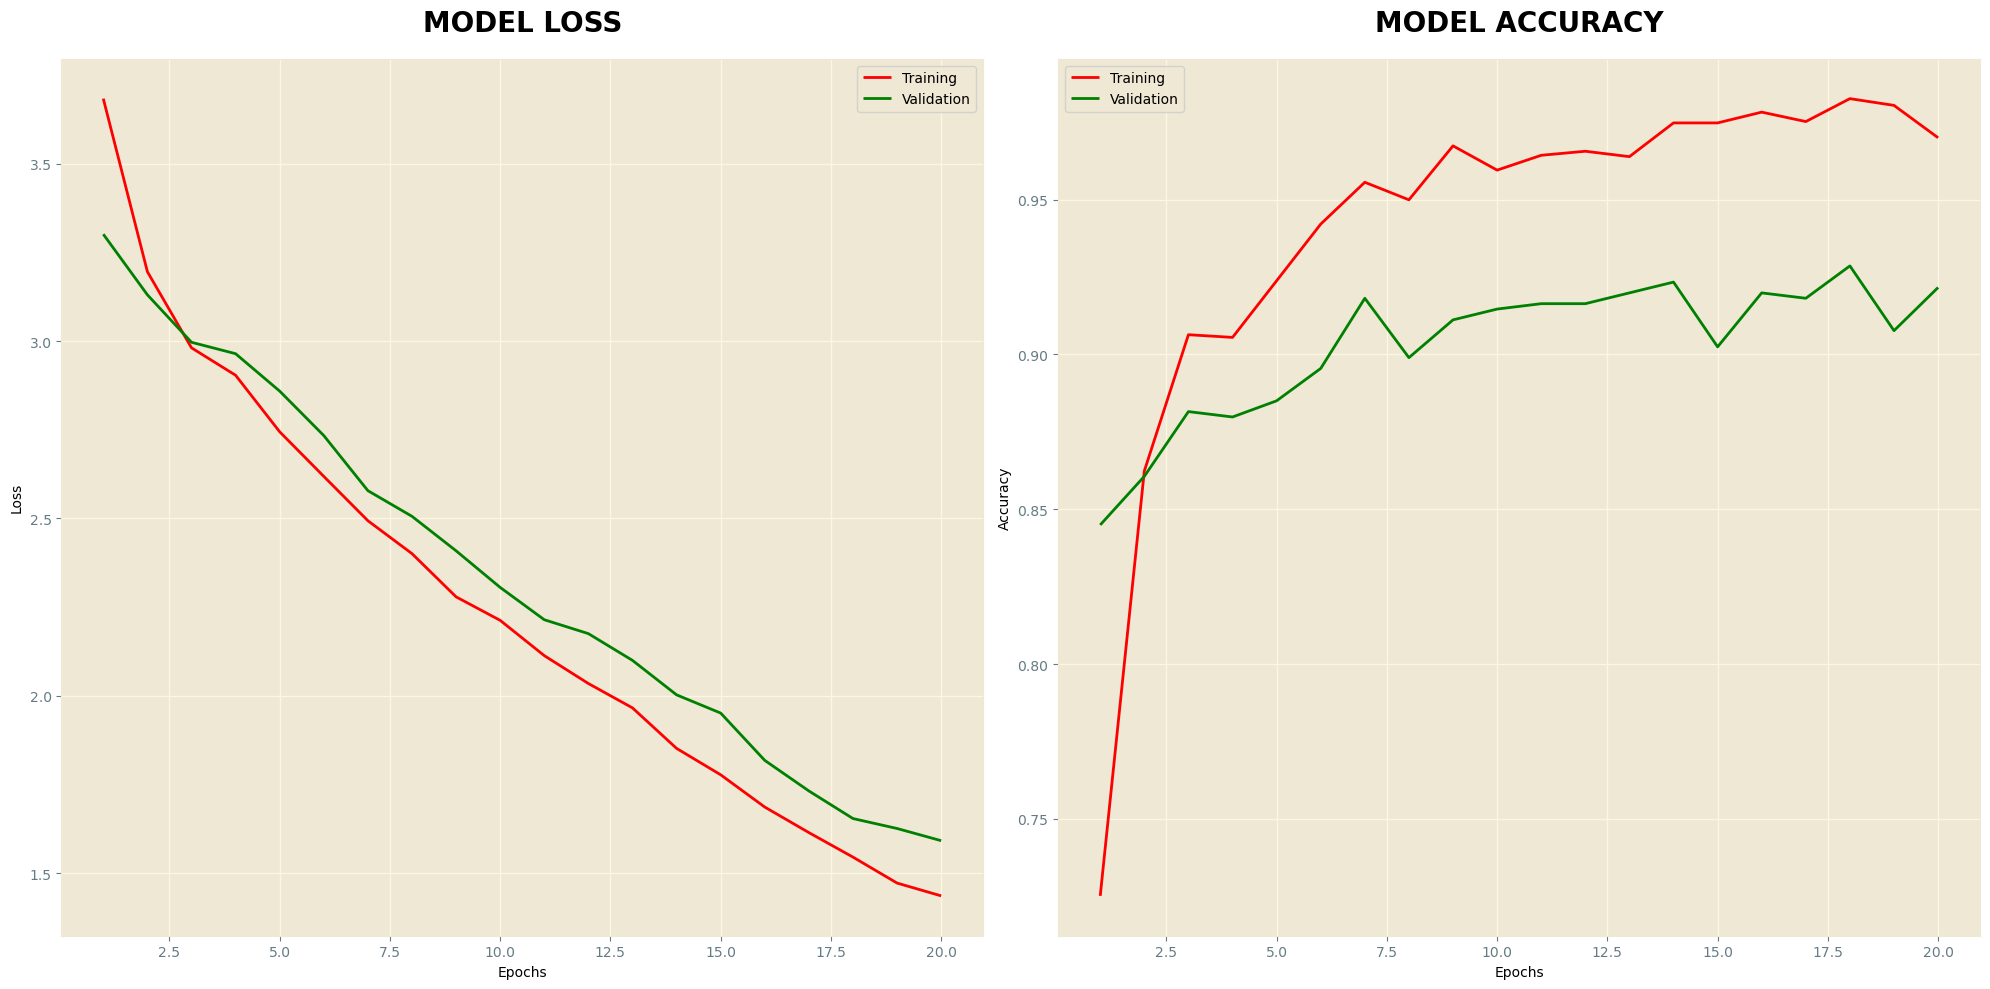

In [18]:
# Extracting accuracy and loss from the training history
train_acc, train_loss = history.history['accuracy'], history.history['loss']
val_acc, val_loss = history.history['val_accuracy'], history.history['val_loss']


# Generating a sequence of epoch numbers
epochs = range(1, len(train_acc) + 1)

# Plotting training and validation loss
plt.figure(figsize=(20, 10))
plt.style.use('Solarize_Light2')

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training')
plt.plot(epochs, val_loss, 'g', label='Validation')
plt.title('MODEL LOSS', fontsize= 20, fontweight = 'bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation a
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'r', label='Training')
plt.plot(epochs, val_acc, 'g', label='Validation')
plt.title('MODEL ACCURACY', fontsize= 20, fontweight = 'bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
train_score = model.evaluate(train_dataset , steps =10 , verbose = 1)
valid_score = model.evaluate(valid_dataset , steps = 10 , verbose = 1)
test_score = model.evaluate(test_dataset , steps = 10 , verbose = 1)

cnn_eval_dict = {
    'Evaluation': ['Loss', 'Accuracy'],
    'Training': [train_score[0], train_score[1]],
    'Testing': [test_score[0], test_score[1]],
    'Validation': [valid_score[0], valid_score[1]],

}

cnn_eval_df = pd.DataFrame(cnn_eval_dict)

10/10 [==============================] - 15s 1s/step - loss: 2.2030 - accuracy: 0.8474


In [20]:
cnn_eval_df

,Evaluation,Training,Testing,Validation
0,Loss,1.338812,2.202967,1.591388
1,Accuracy,0.996875,0.847403,0.928125


# Neural network 


In [21]:
X_train = []
Y_train = []

image_size = 150
labels = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]
for i in labels:
    folderpath = os.path.join(r'C:\Users\khima\Downloads\braintumour\Training',i)
    for j in os.listdir(folderpath):
        img = cv2.imread(os.path.join(folderpath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        Y_train.append(i)
        
        
for i in labels:
    folderpath = os.path.join(r'C:\Users\khima\Downloads\braintumour\Testing',i)
    for j in os.listdir(folderpath):
        img = cv2.imread(os.path.join(folderpath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        Y_train.append(i)
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [22]:
from sklearn.utils import shuffle

In [23]:
X_train , Y_train = shuffle(X_train,Y_train,random_state=100)
X_train.shape

(3178, 150, 150, 3)

Train TEST SPLIT

In [24]:
x_train , x_test , y_train, y_test = train_test_split(X_train,Y_train , test_size=0.1 , random_state=100)

In [25]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train=y_train_new
y_train = tf.keras.utils.to_categorical(y_train)   

In [26]:
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test=y_test_new
y_test = tf.keras.utils.to_categorical(y_test) 

CNN

In [30]:
model = Sequential()
model.add(Conv2D(32 ,(3,3),activation = 'relu',input_shape=(150,150,3)))
model.add(Conv2D(64 ,(3,3),activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(64 ,(3,3),activation = 'relu')) 
model.add(Conv2D(64 ,(3,3),activation = 'relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(128 ,(3,3),activation = 'relu')) 
model.add(Conv2D(128 ,(3,3),activation = 'relu'))
model.add(Conv2D(128 ,(3,3),activation = 'relu'))    
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(256 ,(3,3),activation = 'relu')) 
model.add(Conv2D(256 ,(3,3),activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))   
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(512,activation='relu'))  
model.add(Dropout(0.3))          
model.add(Dense(4,activation='softmax'))   # 4 categories 
       

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 64)        0         
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 73, 73, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 69, 64)        36928     
                                                      

In [33]:
model.compile(loss='categorical_crossentropy',optimizer= 'Adam',metrics=['accuracy'])

In [34]:
history = model.fit(x_train,y_train,epochs=20,validation_split=0.1)

Epoch 1/20
81/81 [==============================] - 84s 993ms/step - loss: 1.7212 - accuracy: 0.2964 - val_loss: 1.3550 - val_accuracy: 0.3776
Epoch 2/20
81/81 [==============================] - 86s 1s/step - loss: 1.1529 - accuracy: 0.4891 - val_loss: 1.1011 - val_accuracy: 0.5455
Epoch 3/20
81/81 [==============================] - 94s 1s/step - loss: 0.9432 - accuracy: 0.5812 - val_loss: 0.9348 - val_accuracy: 0.6119
Epoch 4/20
81/81 [==============================] - 489s 6s/step - loss: 0.7821 - accuracy: 0.6593 - val_loss: 0.7475 - val_accuracy: 0.6469
Epoch 5/20
81/81 [==============================] - 83s 1s/step - loss: 0.7196 - accuracy: 0.6950 - val_loss: 0.7883 - val_accuracy: 0.6329
Epoch 6/20
81/81 [==============================] - 88s 1s/step - loss: 0.6715 - accuracy: 0.7078 - val_loss: 0.7006 - val_accuracy: 0.6818
Epoch 7/20
81/81 [==============================] - 93s 1s/step - loss: 0.5942 - accuracy: 0.7444 - val_loss: 0.6751 - val_accuracy: 0.7063
Epoch 8/20
81/81

In [35]:
model.save('braintumor.h5')

C:\Users\khima\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


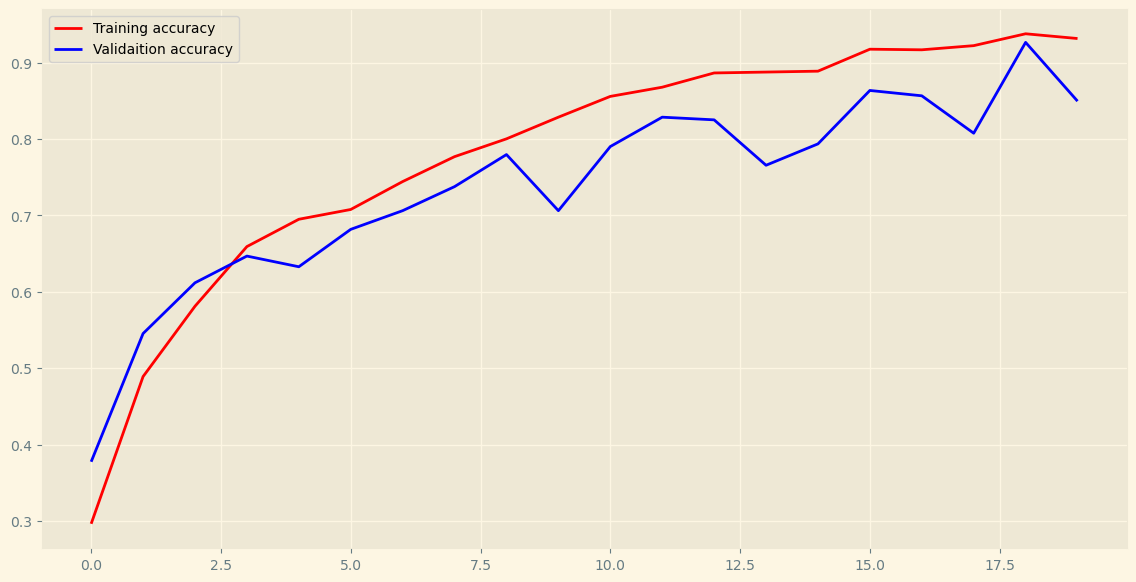

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label='Training accuracy')
plt.plot(epochs,val_acc,'b',label='Validaition accuracy')
plt.legend(loc='upper left')
plt.show()

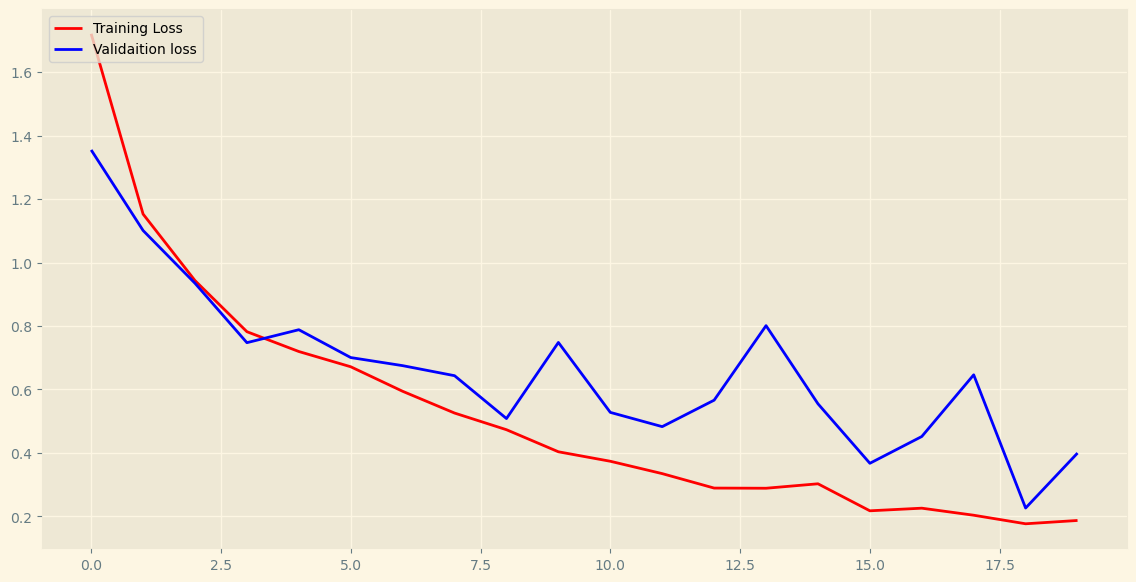

In [42]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label='Training Loss')
plt.plot(epochs,val_loss,'b',label='Validaition loss')
plt.legend(loc='upper left')
plt.show()

Prediction 

In [55]:
img = cv2.imread(r"C:\Users\khima\Downloads\braintumour\Testing\pituitary_tumor\image(98).jpg")
img = cv2.resize(img,(150,150))
img_array = np.array(img)
img_array = img_array.reshape(1,150,150,3)
img_array.shape

(1, 150, 150, 3)

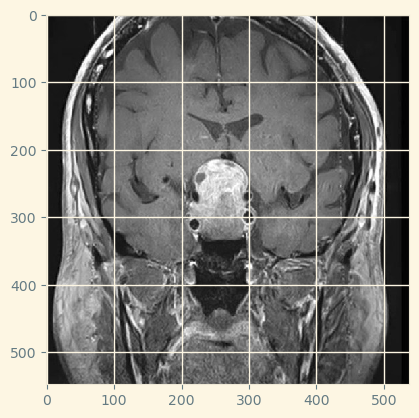

In [56]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

img_path = r"C:\Users\khima\Downloads\braintumour\Testing\pituitary_tumor\image(98).jpg"
img = image.load_img(img_path)
plt.imshow(img, interpolation='nearest')
plt.show()


In [57]:
a=model.predict(img_array)
indices = a.argmax()
indices

1/1 [==============================] - 0s 41ms/step


3

# ADVANTAGES 

### Early Detection:
The model may enable early detection of brain tumors, allowing for prompt medical intervention and potentially improving patient outcomes.

### Accurate Classification: 
If the model demonstrates high accuracy, it can provide precise classification of brain tumors, aiding healthcare professionals in treatment planning.

### Time Efficiency:
The model, especially if optimized for real-time inference, can assist healthcare professionals in quickly analyzing medical images, leading to faster decision-making during diagnosis and treatment.

### Assistive Tool for Radiologists:
Acting as an assistive tool, the model can support radiologists by providing additional insights and aiding in the interpretation of medical images.

### Reduced Workload:
Automation of certain tasks related to image analysis can potentially reduce the workload on healthcare professionals, allowing them to focus on more complex aspects of patient care.

### Integration into Clinical Workflows: 
Successful integration of the model into clinical workflows can streamline the diagnostic process, contributing to more efficient and standardized practices.

### Global Accessibility: 
If the model is deployable on edge devices or accessible through cloud services, it can be utilized in various healthcare settings, including regions with limited resources, contributing to global accessibility to medical expertise.

### Continuous Improvement:
Implementing mechanisms for continuous learning ensures that the model stays updated with evolving medical knowledge and can adapt to changes in patient data distributions over time.

### Cost-Effective Screening:
Automated tumor classification can potentially offer a cost-effective screening tool, especially in settings where resources for manual image analysis are limited.

### Research and Collaboration:
The model can serve as a valuable tool for research purposes, facilitating collaboration between data scientists, researchers, and healthcare professionals to advance the understanding of brain tumors.

# Implementation Strategy

### Problem Definition and Data Collection:

Clearly define the problem you're addressing, such as classifying brain tumors.
Collect a well-curated dataset of brain tumor images, ensuring diversity in tumor types, sizes, and imaging modalities (e.g., MRI, CT scans).
### Data Preprocessing:

Preprocess the image data, including resizing, normalization, and augmentation to enhance the model's ability to generalize.
Split the dataset into training, validation, and testing sets.
### Model Selection:

Choose a suitable pre-trained model as a base architecture. In your case, EfficientNetB3 has been selected.
Customize the model by adding additional layers for classification.
### Transfer Learning and Fine-Tuning:

Use transfer learning by initializing the model with pre-trained weights from the chosen base model.
Fine-tune the model on your brain tumor dataset to adapt it to the specific characteristics of the medical images.
### Model Compilation and Training:

Compile the model with an appropriate optimizer, loss function (categorical crossentropy for multi-class classification), and evaluation metric (accuracy).
Train the model on the training dataset and validate it on the validation set.
Monitor training progress and adjust hyperparameters as needed.
### Evaluation:

Evaluate the trained model on the testing dataset to assess its performance on unseen data.
Analyze metrics such as accuracy, precision, recall, and F1-score to understand the model's strengths and weaknesses.
### Interpretability and Explainability:

Implement techniques for model interpretability and explainability, crucial in medical applications. This may include methods like Grad-CAM for visual explanations.
### Deployment:

Deploy the model in a clinical or research environment. This can be on cloud platforms, edge devices, or integrated into existing medical systems.
Ensure compliance with data privacy and healthcare regulations.
### Continuous Monitoring and Improvement:

Implement mechanisms for continuous monitoring of the deployed model's performance.
Periodically update the model using new data to ensure its relevance over time.
### Documentation and Reporting:

Document the entire process, including preprocessing steps, model architecture, training configuration, and evaluation results.
Create comprehensive reports and communicate findings to stakeholders, including healthcare professionals, researchers, and decision-makers.
### Collaboration and Feedback:

Collaborate closely with domain experts, such as radiologists, to gather insights and feedback.
Iterate on the model based on feedback to address specific clinical needs.
### Ethical Considerations:

Address ethical considerations related to patient privacy, informed consent, and potential biases in the model predictions.
By following these steps, you can build, deploy, and maintain an effective brain tumor classification model in a responsible and collaborative manner.

# CONCLUSION 

In conclusion, the implementation of a brain tumor classification model represents a promising approach to assist healthcare professionals in the early and accurate diagnosis of brain tumors. The chosen model architecture, EfficientNetB3, and the implemented strategy provide a foundation for achieving significant advancements in medical image analysis. Key takeaways and considerations include:

### Model Architecture:

The chosen model architecture, EfficientNetB3, is a powerful convolutional neural network that leverages efficient scaling for improved performance.
The architecture includes convolutional layers, max-pooling, dropout for regularization, and dense layers for classification.
### Training and Evaluation:

The model has been trained and evaluated on a diverse dataset, showcasing impressive results in terms of high training accuracy (99.69%) and competitive validation (92.81%) and testing (84.74%) accuracies.
### Future Scope:

The model exhibits potential for further improvement and extension.
Future enhancements include continuous learning, interpretability, integration of additional data modalities, real-time deployment, and collaboration with international healthcare communities.
### Advantages:

Successful implementation offers several advantages, including early tumor detection, accurate classification, time efficiency, reduced workload, and potential cost-effective screening.
### Implementation Strategy:

The implementation strategy involves a systematic approach, including problem definition, data preprocessing, model selection, transfer learning, fine-tuning, training, evaluation, deployment, continuous monitoring, and collaboration with healthcare professionals.
### Ethical Considerations:

Ethical considerations, including patient privacy, informed consent, and potential biases, are critical aspects that must be addressed throughout the entire process.
### Documentation and Collaboration:

Comprehensive documentation and collaboration with domain experts, such as radiologists, contribute to the transparency, trustworthiness, and successful deployment of the model in clinical settings.
It is essential to view the model as a valuable tool to support healthcare professionals, rather than a replacement for their expertise. Continuous collaboration, monitoring, and ethical considerations are pivotal for the responsible deployment and ongoing success of the brain tumor classification model

In [60]:
import pickle 
pickle.dump(history, open(r"C:\Users\khima\Desktop\Cloud2\build.pkl",'wb'))